In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D ,DepthwiseConv2D ,SeparableConv2D 
from keras.layers import Activation, Flatten, Dropout, Input, GlobalAveragePooling2D, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 10s 0us/step


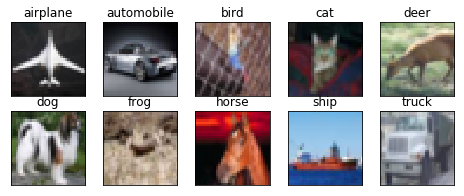

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Rewriting Base Model


*   **Use of Functional API of Keras**
*   **Use of Advanced Convolutions**



In [8]:
input = Input(shape=(32,32,3))

#First convolution - Normal
Conv1 = Convolution2D(32,3,3, activation ='relu', border_mode ='same',name ='Conv1')(input)
BN1 = BatchNormalization(name='bn1')(Conv1)
Drop1 = Dropout(0.1)(BN1)

#Next convolution - Spatially Seperable
SpacSepConv1 = Convolution2D(64,3,1, activation='relu',border_mode ='same', name='SpacSepConv1')(Drop1) #3x1
BN2 = BatchNormalization(name='bn2')(SpacSepConv1)

SpacSepConv2 = Convolution2D(64,1,3, activation='relu',border_mode ='same', name='SpacSepConv2')(BN2) #3x1
BN3 = BatchNormalization(name='bn3')(SpacSepConv2)
Drop2 = Dropout(0.2)(BN3)

MP1 = MaxPooling2D((2,2), name='MP1')(Drop2)

#Next convolution - Depthwise Seperable
DepthConv = SeparableConv2D(128,3,3, activation='relu',border_mode ='same', name='DepthConv')(MP1) 
BN4 = BatchNormalization(name='bn4')(DepthConv)
Drop3 = Dropout(0.2)(BN4)

#Next convolution - Grouped Convolution of (3,3) and (3,3) without dilation
Group1 = Convolution2D(128,3,3, activation='relu',border_mode ='same', name='group1')(Drop3) 
BN5 = BatchNormalization(name='bn5')(Group1)

Group2 = Convolution2D(128,5,5, activation='relu',border_mode ='same', name='group2')(Drop3) 
BN6 = BatchNormalization(name='bn6')(Group2)

Concat1 = Concatenate(name ='concat1')([BN5,BN6])
Drop4 = Dropout(0.2)(Concat1)

#Next convolution - Grouped Convolution of (3,3) with dilation_rate=1 and (3,3) with dilation_rate=2
GroupDil1 = Convolution2D(256,3,3, activation='relu',border_mode ='same', name='GD1',dilation_rate=1)(Drop4) 
BN7 = BatchNormalization(name='bn7')(GroupDil1)

GroupDil2 = Convolution2D(256,3,3, activation='relu',border_mode ='same', name='GD2',dilation_rate=2)(Drop4) 
BN8 = BatchNormalization(name='bn8')(GroupDil2)

Concat2 = Concatenate(name ='concat2')([BN7,BN8])
Drop5 = Dropout(0.1)(Concat2)

MP2 = MaxPooling2D((2,2), name='MP2')(Drop5)

#Final convolution
dense = Convolution2D(10,8,8, activation='relu',border_mode ='same', name='dense')(MP2) 
point = Convolution2D(10,1,1, activation='relu',border_mode ='same', name='point')(dense) 

gap = GlobalAveragePooling2D()(point)
output = Activation('softmax')(gap)

model = Model(inputs=[input], outputs=[output])

model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", name="Conv1", padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1), activation="relu", name="SpacSepConv1", padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3), activation="relu", name="SpacSepConv2", padding="same")`
  if sys.path[0] == '':
W0902 17:26:35.474560 140032991618944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 32, 32, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 32, 32, 32)   0           bn1[0][0]                        
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", name="GD1", dilation_rate=1, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", name="GD2", dilation_rate=2, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (8, 8), activation="relu", name="dense", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), activation="relu", name="point", padding="same")`


W0902 17:27:36.615385 140032991618944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  
W0902 17:27:36.745477 140032991618944 deprecation.py:323

Epoch 1/50
390/390 [==============================] - 49s 127ms/step - loss: 2.0701 - acc: 0.2169 - val_loss: 1.9034 - val_acc: 0.3361
Epoch 2/50
390/390 [==============================] - 43s 109ms/step - loss: 1.4485 - acc: 0.4549 - val_loss: 1.5951 - val_acc: 0.4820
Epoch 3/50
390/390 [==============================] - 42s 108ms/step - loss: 1.0350 - acc: 0.6220 - val_loss: 1.2952 - val_acc: 0.6000
Epoch 4/50
390/390 [==============================] - 42s 108ms/step - loss: 0.7603 - acc: 0.7420 - val_loss: 0.9156 - val_acc: 0.6947
Epoch 5/50
390/390 [==============================] - 42s 108ms/step - loss: 0.5933 - acc: 0.7998 - val_loss: 0.7621 - val_acc: 0.7537
Epoch 6/50
390/390 [==============================] - 42s 107ms/step - loss: 0.4779 - acc: 0.8390 - val_loss: 0.7148 - val_acc: 0.7651
Epoch 7/50
390/390 [==============================] - 42s 108ms/step - loss: 0.3836 - acc: 0.8686 - val_loss: 0.7410 - val_acc: 0.7706
Epoch 8/50
390/390 [==============================] - 4

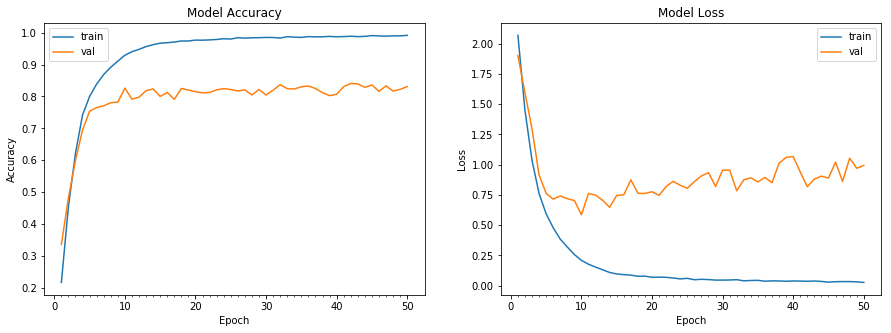

Accuracy on test data is: 83.09


In [10]:
from keras.preprocessing.image import ImageDataGenerator

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))